In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc, norm
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples
matplotlib.rc('font', size=14,family='serif')
matplotlib.rc('legend', fontsize=14)

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 2
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = 0.46
scale = 0.1
d =  norm(loc= f_mean,scale=scale)

f = lambda x: d.logpdf(x) #mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=True)
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

(2, 1) (2, 1)
Testing lightweight implementation


sample: 100%|██████████| 512/512 [00:00<00:00, 675.31it/s, 7 steps of size 6.01e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 2.42s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     13.35     24.59      7.13      0.59     18.25     17.98      0.99
        kernel_length[0]      0.55      0.35      0.46      0.18      1.20     13.12      0.95
            kernel_tausq      1.38      1.85      0.61      0.08      3.82     16.48      0.94
              kernel_var     11.37      8.80      8.09      2.74     24.92     25.38      1.12

Number of divergences: 0


In [3]:
### plotting functions

def plot_gp(test_x,ax):
    mu, var = gp.posterior(test_x,single=True)
    std = jnp.sqrt(var)
    ax.plot(test_x,test_y,label='True',color='k')
    ax.scatter(train_x,train_y,color='k')
    ax.plot(test_x,mu,label='GP')
    ax.fill_between(test_x[:,0],mu-1.96*std,mu+1.96*std,alpha=0.4)
    ax.set(xlabel=r'$x$',ylabel=r'$f(x)$')
    # ax.legend()

def plot_hyperparams(gp,fig,ax):
    colors = matplotlib.colormaps['YlGn']
    l = np.array(gp.samples["kernel_length"].squeeze(-1))
    o = np.array(gp.samples["kernel_var"])
    lp = -np.array(gp.samples["minus_log_prob"])
    lp_min, lp_max = np.min(lp), np.max(lp)
    cols = np.linspace(lp_min,lp_max,len(lp))
    cols = (cols - lp_min)/(lp_max - lp_min)
    ax.scatter(l,o)
    sc = ax.scatter(l,o,c = lp, vmin = lp_min, vmax=lp_max,cmap= colors)
    fig.colorbar(sc,ax=ax)
    ax.set(xlabel=r'lengthscale',ylabel=r'outputscale')

def plot_acq(acq_x,acq_vals,next_x,next_val,mc_points,gp,ax):
    ax.plot(acq_x,acq_vals)
    ax.scatter(next_x,next_val,color='r',label=r'next point')
    ax.set(xlabel=r'$x$',ylabel=r'$\mathrm{IPV}(x)$')
    _, pre_var = gp.posterior(mc_points,unstandardize=False)
    pre_var = pre_var.mean()
    for pt in gp.train_x:
        ax.axvline(pt,color='k',ls='-.',lw=0.5)
        ax.axhline(pre_var,color='k',lw=1)
    # ax.legend()

INFO:[NS]: Nested Sampling took 2.99s
INFO:[NS]: jaxns did 1338 likelihood evaluations


LogZ info logz_mean: = 1.3429, dlogz: = 0.2006, 


INFO:[AQ]: Acquisition optimization took 1.74 s


Next point at x = [0.79289071] with acquisition function value = 0.057245573128966956


sample: 100%|██████████| 384/384 [00:00<00:00, 538.45it/s, 15 steps of size 3.09e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 1.11s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.46s
INFO:[NS]: jaxns did 2393 likelihood evaluations


LogZ info logz_mean: = -0.3715, dlogz: = 0.2634, 


INFO:[AQ]: Acquisition optimization took 1.77 s


Next point at x = [0.44423349] with acquisition function value = 0.33529919585675705


sample: 100%|██████████| 384/384 [00:00<00:00, 548.88it/s, 7 steps of size 5.90e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.13s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.08s
INFO:[NS]: jaxns did 2538 likelihood evaluations


LogZ info logz_mean: = -0.2553, dlogz: = 0.2729, 


INFO:[AQ]: Acquisition optimization took 1.60 s


Next point at x = [0.35955711] with acquisition function value = 0.01362893783910044


sample: 100%|██████████| 384/384 [00:00<00:00, 598.91it/s, 7 steps of size 5.01e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 1.02s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 1.92s
INFO:[NS]: jaxns did 2409 likelihood evaluations


LogZ info logz_mean: = -0.2177, dlogz: = 0.2764, 


INFO:[AQ]: Acquisition optimization took 1.44 s


Next point at x = [0.64561314] with acquisition function value = 0.00017042651266351017


sample: 100%|██████████| 384/384 [00:00<00:00, 521.31it/s, 7 steps of size 8.31e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 1.12s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 1.89s
INFO:[NS]: jaxns did 2471 likelihood evaluations


LogZ info logz_mean: = -0.1063, dlogz: = 0.2715, 


INFO:[AQ]: Acquisition optimization took 0.90 s


Next point at x = [0.40858072] with acquisition function value = 0.00016121440735573922


sample: 100%|██████████| 384/384 [00:00<00:00, 590.30it/s, 7 steps of size 6.05e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 1.03s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 1.78s
INFO:[NS]: jaxns did 2391 likelihood evaluations


LogZ info logz_mean: = -0.2248, dlogz: = 0.2753, 


INFO:[AQ]: Acquisition optimization took 1.10 s


Next point at x = [0.55029923] with acquisition function value = 0.0001749180096073319


sample: 100%|██████████| 384/384 [00:00<00:00, 398.85it/s, 7 steps of size 6.56e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.34s


----------------------Step 6 complete----------------------

BO took 32.50 s 


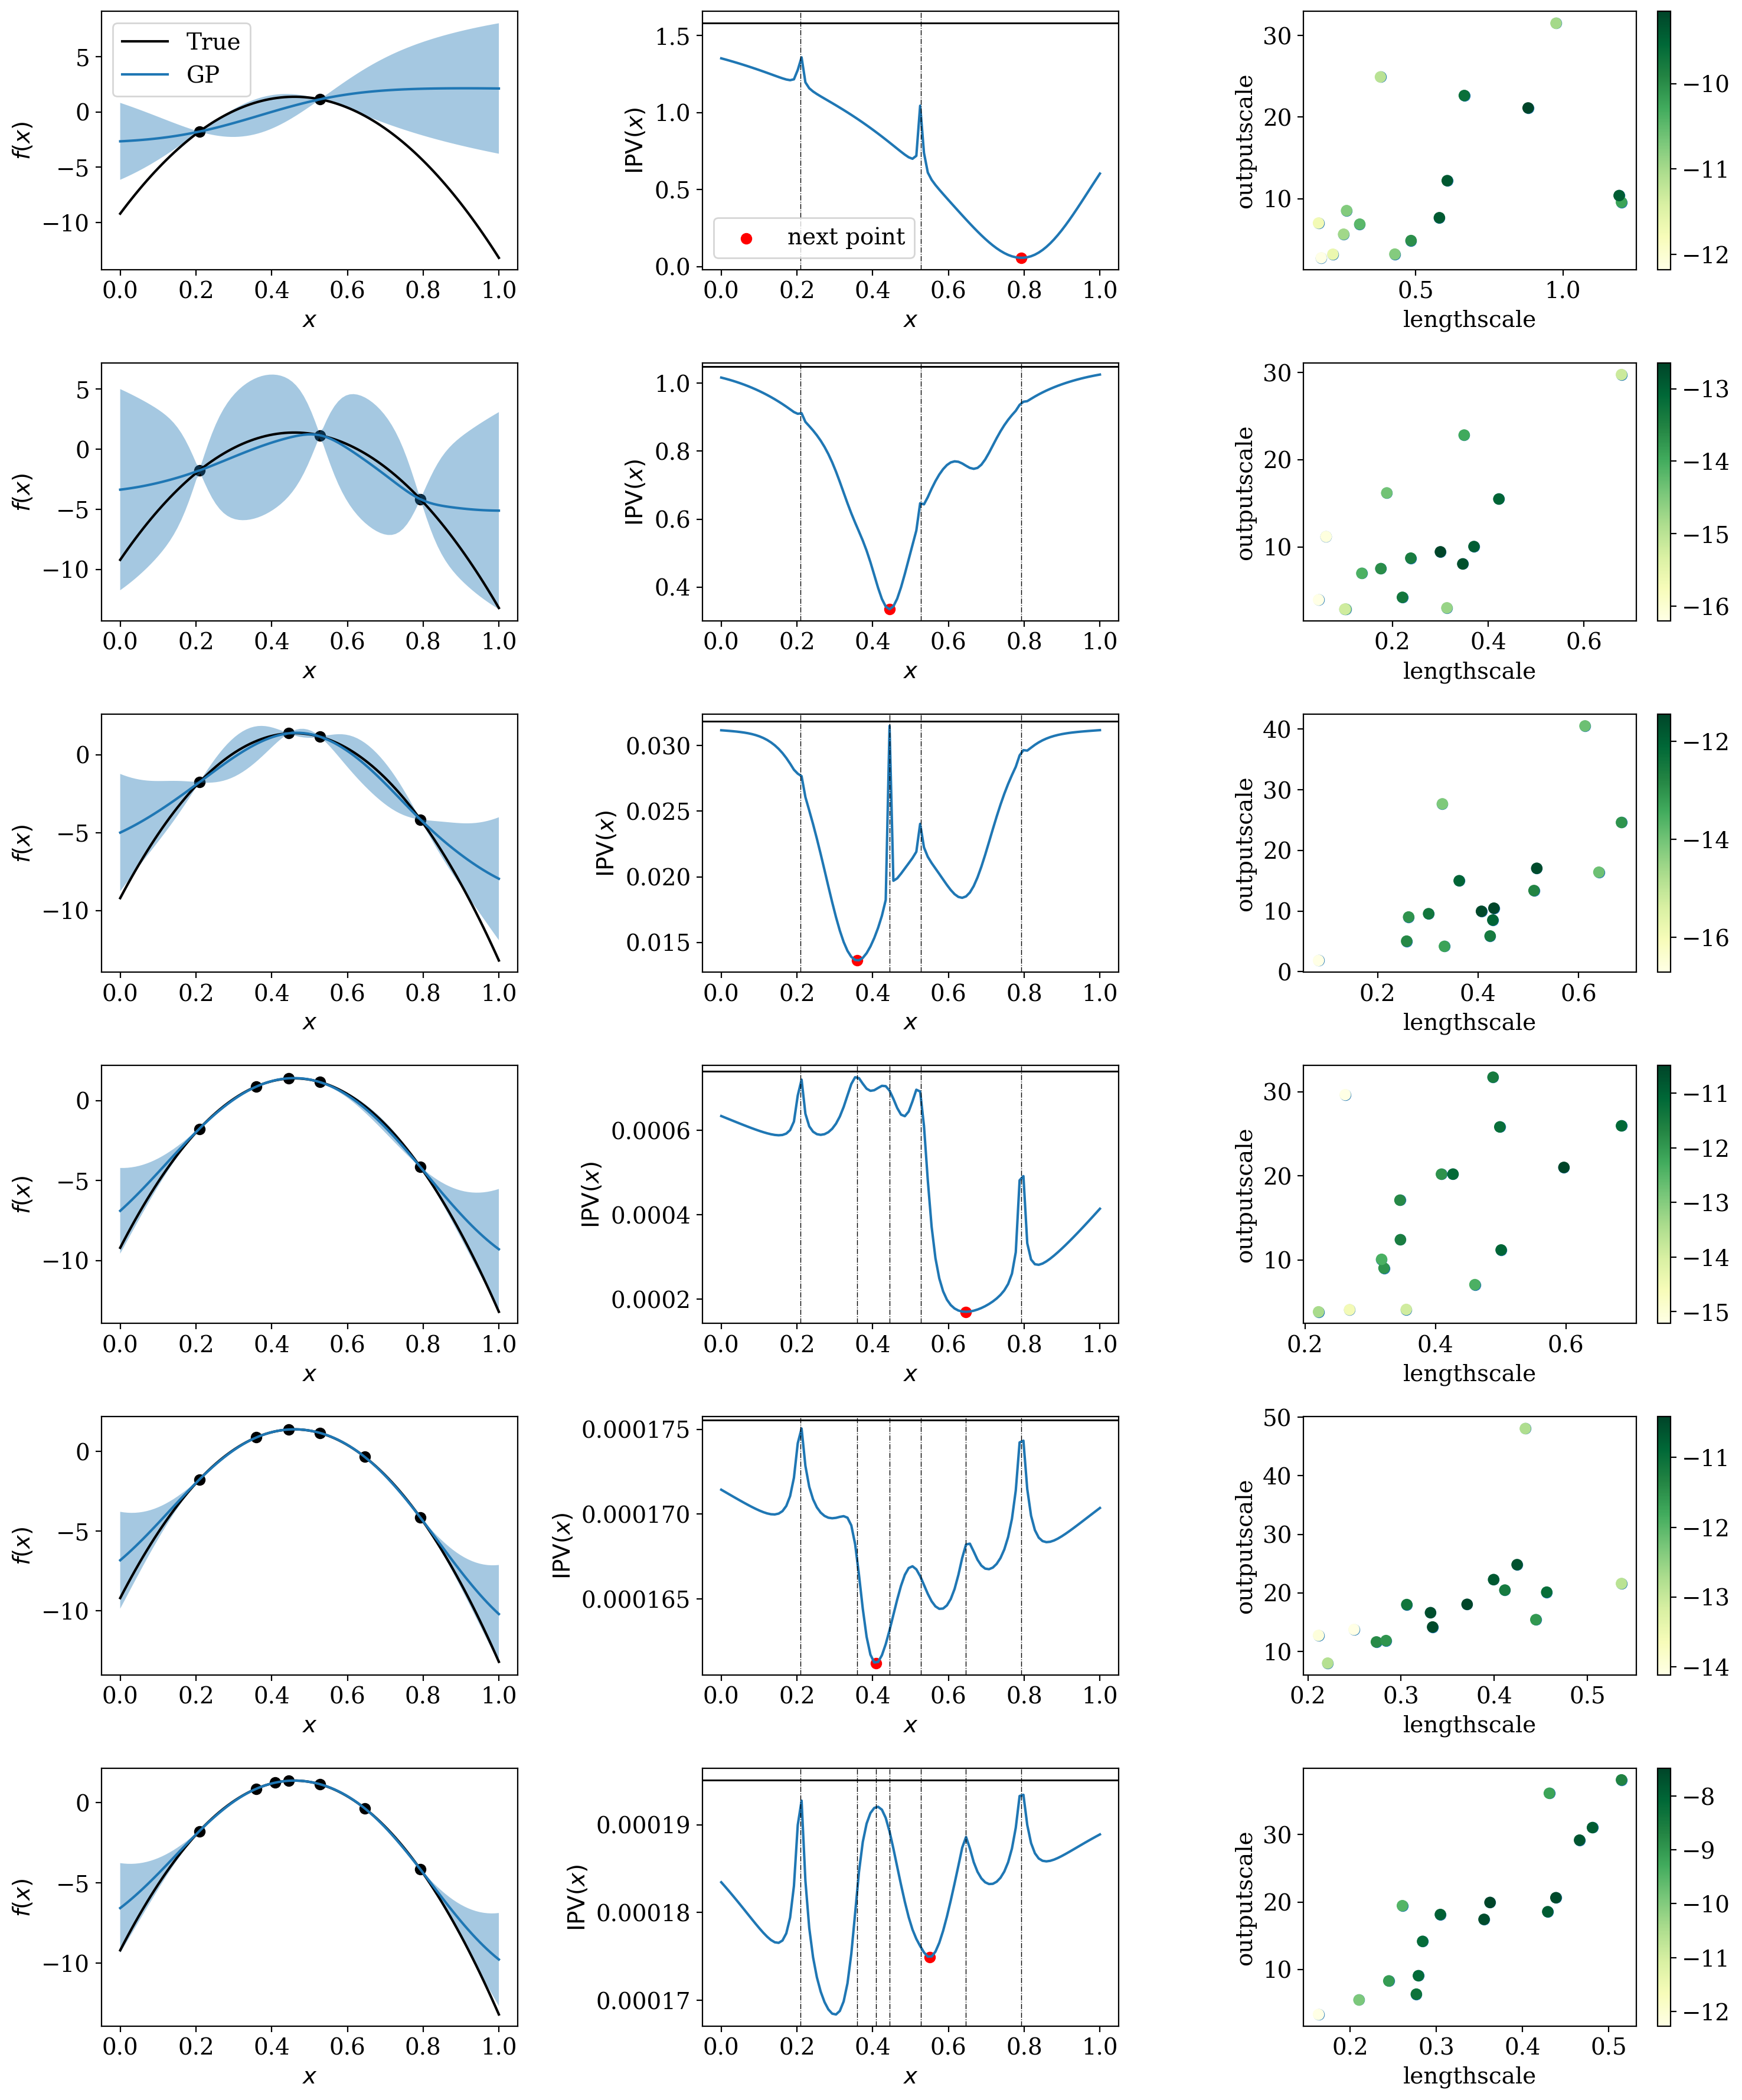

In [4]:
nsteps = 6 # 32
mc_points_size = 8

fig, ax = plt.subplots(nsteps,3,figsize=(15,3*nsteps)) #,sharex='col')
start = time.time()
for i in range(nsteps):
    plot_gp(test_x,ax[i,0])
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    plot_hyperparams(gp,fig,ax[i,2])
    print(f"LogZ info "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    mc_points = samples[:mc_points_size,:]
    acq_func = IPV(gp,mc_points,batch_size=1) #   EI(gp,gp.train_y.max()) 
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform()
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    acq_vals = vmap(acq_func)(test_x)
    # print(acq_vals.shape)
    plot_acq(test_x,acq_vals,next_x,results.fun,mc_points=mc_points,gp=gp,ax=ax[i,1])
    gp = saas_fbgp(train_x,train_y,noise=1e-4)
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.fit(rng_key,warmup_steps=256,num_samples=128,thinning=8,verbose=False)

    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")
fig.tight_layout()
ax[0,0].legend()
ax[0,1].legend() 
# plt.savefig('../output_1d.pdf')

In [5]:
print(gp.samples["kernel_length"].shape)

(16, 1)


In [6]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.0001,num_samples_equal=1000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 3.48s
INFO:[NS]: jaxns did 143993 likelihood evaluations


LogZ info: logz_mean: = 0.0651, dlogz: = 0.1474, 


Removed no burn in
Removed no burn in


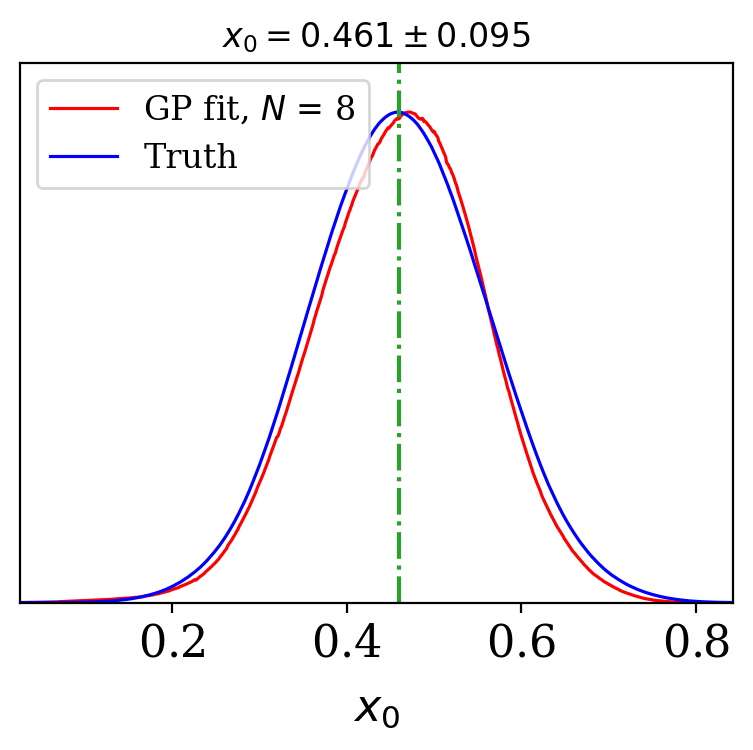

In [7]:
test_samples = np.random.normal(loc=f_mean,scale=scale,size=int(1e4))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=4,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 16
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 12
g.settings.title_limit_fontsize = 12
g.plot_1d([gp_samples,true_samples],'x_0',filled=[True,False],colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','Truth'],
                                contour_lws=[1,1.5],title_limit=1) # type: ignore
g.add_legend([f'GP fit, $N$ = {gp.train_y.shape[0]}','Truth'],legend_loc='upper left')
for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean, color='C2', ls='-.')


In [8]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 2
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = 0.46
scale = 0.1
d =  norm(loc= f_mean,scale=scale)

f = lambda x: d.logpdf(x) #mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

(2, 1) (2, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1344.60it/s, 3 steps of size 6.44e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 0.94s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]    191.99    885.88      5.18      0.53     35.74     34.48      1.01
        kernel_length[0]      0.69      0.47      0.52      0.11      1.50     33.88      0.98
            kernel_tausq      1.67      3.89      0.36      0.07      3.51     21.38      1.07
              kernel_var     16.47      8.44     16.37      5.20     28.29     29.32      0.99

Number of divergences: 0


INFO:[NS]: Nested Sampling took 2.57s
INFO:[NS]: jaxns did 845 likelihood evaluations


LogZ info logz_mean: = 0.4428, dlogz: = 0.1066, 


INFO:[AQ]: Acquisition optimization took 1.66 s


Next point at x = [1.] with acquisition function value = -0.03197493874164829


sample: 100%|██████████| 384/384 [00:00<00:00, 575.13it/s, 7 steps of size 5.46e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 0.79s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.50s
INFO:[NS]: jaxns did 2563 likelihood evaluations


LogZ info logz_mean: = 0.0494, dlogz: = 0.2694, 


INFO:[AQ]: Acquisition optimization took 0.70 s


Next point at x = [0.] with acquisition function value = -0.21191006972153348


sample: 100%|██████████| 384/384 [00:00<00:00, 559.15it/s, 7 steps of size 6.54e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 0.85s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 1.72s
INFO:[NS]: jaxns did 2630 likelihood evaluations


LogZ info logz_mean: = 0.0129, dlogz: = 0.2779, 


INFO:[AQ]: Acquisition optimization took 1.45 s


Next point at x = [0.4788772] with acquisition function value = -0.5051474145727929


sample: 100%|██████████| 384/384 [00:00<00:00, 542.83it/s, 7 steps of size 4.56e-01. acc. prob=0.95]
INFO:[GP]: MCMC elapsed time: 0.84s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 1.97s
INFO:[NS]: jaxns did 2632 likelihood evaluations


LogZ info logz_mean: = -0.0892, dlogz: = 0.2738, 


INFO:[AQ]: Acquisition optimization took 0.45 s


Next point at x = [0.49531004] with acquisition function value = -2.9346679936620997e-17


sample: 100%|██████████| 384/384 [00:00<00:00, 571.59it/s, 7 steps of size 6.19e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 0.79s


----------------------Step 4 complete----------------------

BO took 17.65 s 


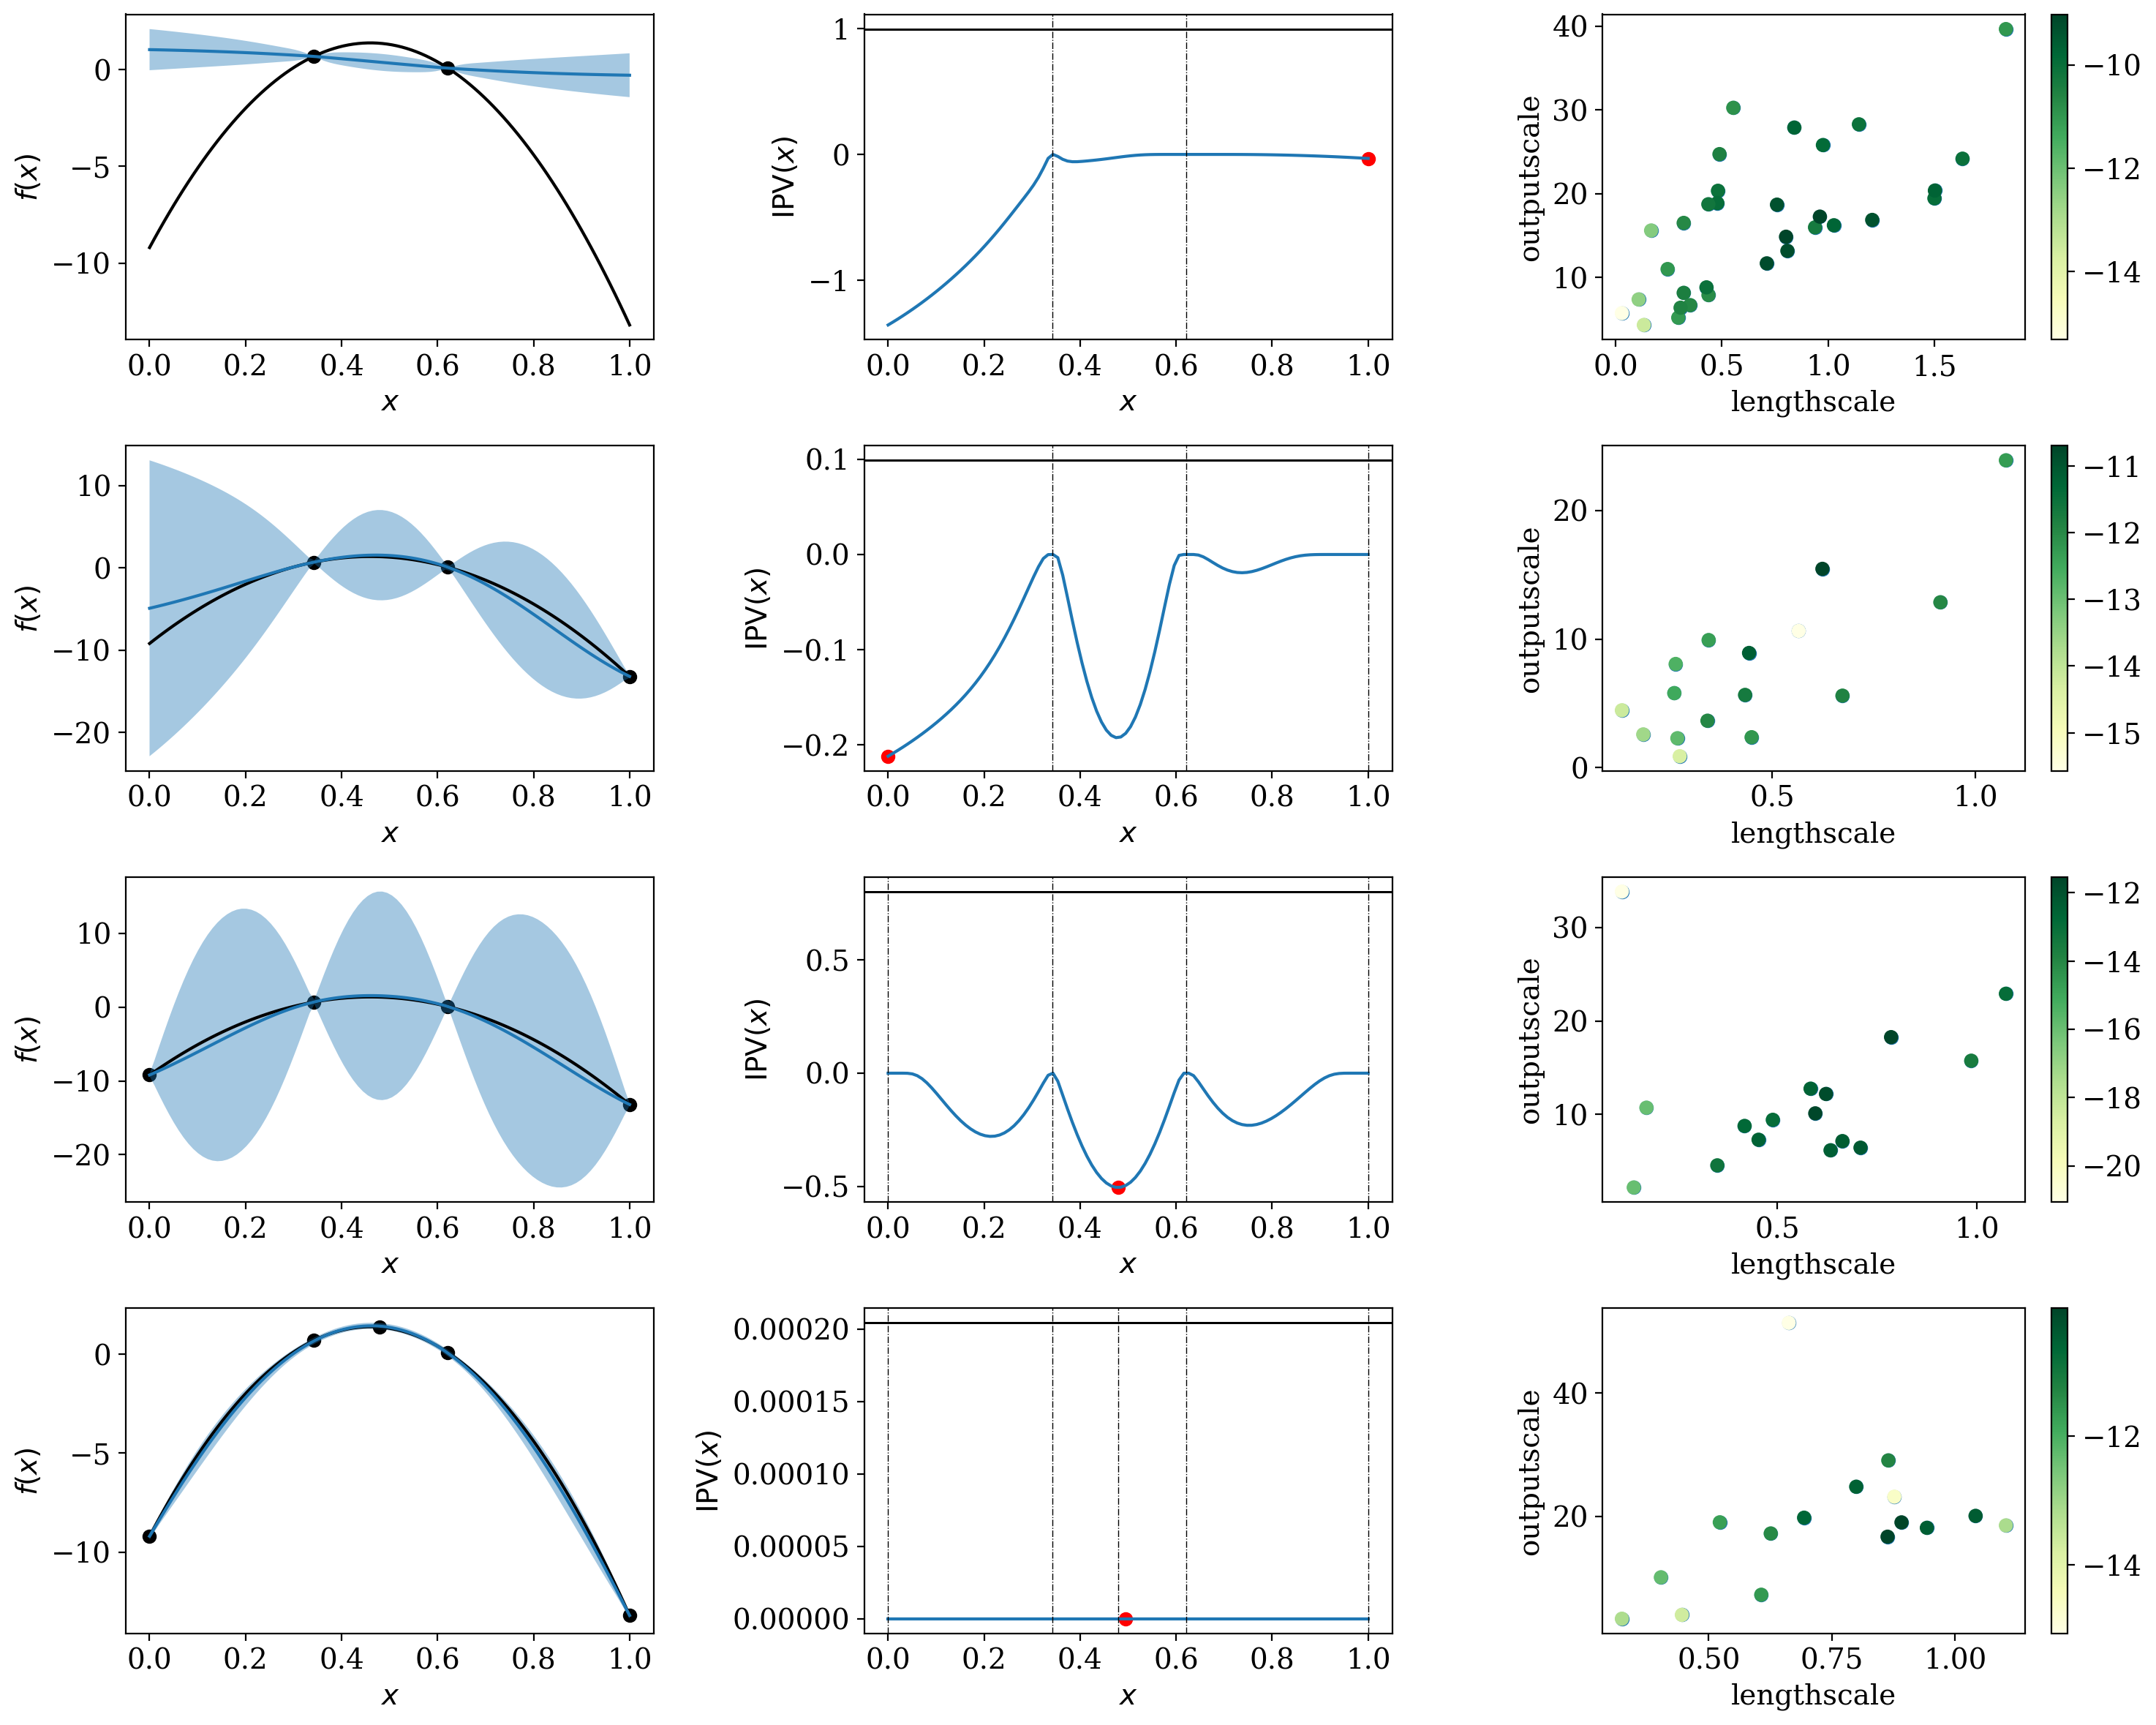

In [9]:
nsteps = 4 # 32
mc_points_size = 8

fig, ax = plt.subplots(nsteps,3,figsize=(15,3*nsteps))
start = time.time()
for i in range(nsteps):
    plot_gp(test_x,ax[i,0])
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    plot_hyperparams(gp,fig,ax[i,2])
    print(f"LogZ info "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    mc_points = samples[:mc_points_size,:]
    acq_func = EI(gp,gp.train_y.max()) 
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform()
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    acq_vals = vmap(acq_func)(test_x)
    # print(acq_vals.shape)
    plot_acq(test_x,acq_vals,next_x,results.fun,mc_points=mc_points,gp=gp,ax=ax[i,1])
    gp = saas_fbgp(train_x,train_y,noise=1e-4)
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.fit(rng_key,warmup_steps=256,num_samples=128,thinning=8,verbose=False)

    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")
fig.tight_layout()

In [10]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.0001,num_samples_equal=1000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 2.26s
INFO:[NS]: jaxns did 150538 likelihood evaluations


LogZ info: logz_mean: = 0.0695, dlogz: = 0.1485, 


Removed no burn in
Removed no burn in


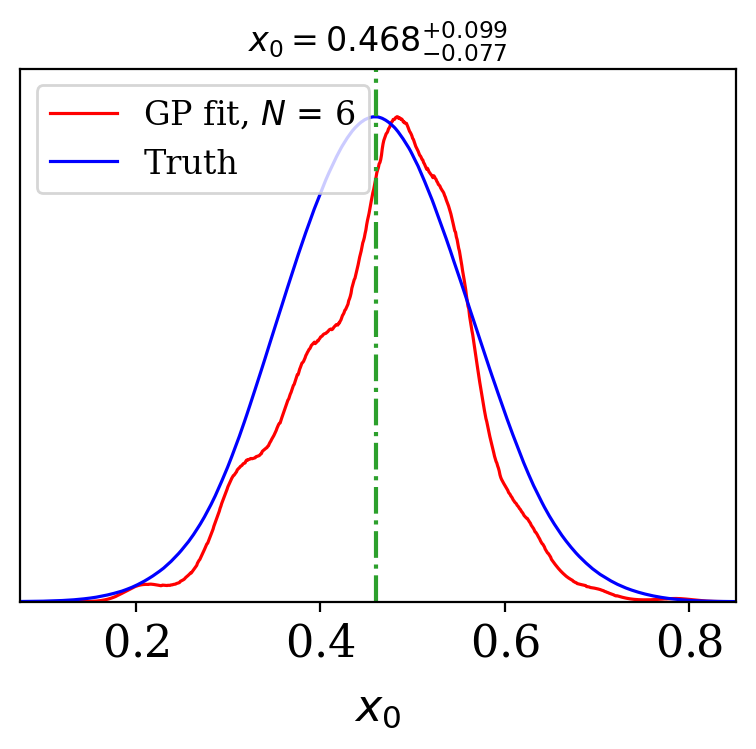

In [11]:
test_samples = np.random.normal(loc=f_mean,scale=scale,size=int(1e4))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=4,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 16
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 12
g.settings.title_limit_fontsize = 12
g.plot_1d([gp_samples,true_samples],'x_0',filled=[True,False],colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','Truth'],
                                contour_lws=[1,1.5],title_limit=1) # type: ignore
g.add_legend([f'GP fit, $N$ = {gp.train_y.shape[0]}','Truth'],legend_loc='upper left')
for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean, color='C2', ls='-.')


#### acquisition 2 points at a time

In [18]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 2
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = 0.46
scale = 0.1
d =  norm(loc= f_mean,scale=scale)

f = lambda x: d.logpdf(x) #mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=True)
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

(2, 1) (2, 1)
Testing lightweight implementation


sample: 100%|██████████| 512/512 [00:00<00:00, 657.47it/s, 7 steps of size 5.89e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.94s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      7.90     14.34      2.87      0.35     19.30     17.41      1.03
        kernel_length[0]      1.07      0.76      1.03      0.08      1.81     19.07      0.94
            kernel_tausq      1.41      2.56      0.37      0.02      7.17     24.91      0.94
              kernel_var     13.23      8.57     11.81      2.04     25.27     20.89      1.13

Number of divergences: 0


In [19]:
### plotting functions

def plot_gp(test_x,ax):
    mu, var = gp.posterior(test_x,single=True)
    std = jnp.sqrt(var)
    ax.plot(test_x,test_y,label='True',color='k')
    ax.scatter(train_x,train_y,color='k')
    ax.plot(test_x,mu,label='GP')
    ax.fill_between(test_x[:,0],mu-1.96*std,mu+1.96*std,alpha=0.4)
    ax.set(xlabel=r'$x$',ylabel=r'$f(x)$')
    ax.legend()

def plot_hyperparams(gp,fig,ax):
    colors = matplotlib.colormaps['YlGn']
    l = np.array(gp.samples["kernel_length"].squeeze(-1))
    o = np.array(gp.samples["kernel_var"])
    lp = -np.array(gp.samples["minus_log_prob"])
    lp_min, lp_max = np.min(lp), np.max(lp)
    cols = np.linspace(lp_min,lp_max,len(lp))
    cols = (cols - lp_min)/(lp_max - lp_min)
    ax.scatter(l,o)
    sc = ax.scatter(l,o,c = lp, vmin = lp_min, vmax=lp_max,cmap= colors)
    fig.colorbar(sc,ax=ax)
    ax.set(xlabel=r'lengthscale',ylabel=r'outputscale')

def plot_acq(acq_x,acq_vals,next_x,next_val,mc_points,gp,ax):
    ax.plot(acq_x,acq_vals)
    for next in next_x:
        ax.axvline(next,color='r',ls='--') #,label=r'next point')
    ax.set(xlabel=r'$x$',ylabel=r'$\mathrm{IPV}(x)$')
    _, pre_var = gp.posterior(mc_points,unstandardize=False)
    pre_var = pre_var.mean()
    for pt in gp.train_x:
        ax.axvline(pt,color='k',ls='-.',lw=0.5)
        ax.axhline(pre_var,color='k',lw=1)
    ax.legend()

INFO:[NS]: Nested Sampling took 1.72s
INFO:[NS]: jaxns did 1816 likelihood evaluations


LogZ info logz_mean: = 5.4022, dlogz: = 0.2985, 
[0.79547189 0.19590383]


INFO:[AQ]: Acquisition optimization took 1.91 s


Next point at x = [0.23559997 0.05582942] with acquisition function value = 0.04407647647230724
(2, 1)


sample: 100%|██████████| 384/384 [00:00<00:00, 599.02it/s, 7 steps of size 5.22e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 0.75s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 1.60s
INFO:[NS]: jaxns did 2595 likelihood evaluations


LogZ info logz_mean: = -0.0815, dlogz: = 0.2805, 
[0.6364672  0.36995375]


INFO:[AQ]: Acquisition optimization took 2.06 s


Next point at x = [0.57082772 0.39200112] with acquisition function value = 0.004434244075734617
(2, 1)


sample: 100%|██████████| 384/384 [00:00<00:00, 608.91it/s, 7 steps of size 6.37e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 0.72s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.11s
INFO:[NS]: jaxns did 2483 likelihood evaluations


LogZ info logz_mean: = -0.0880, dlogz: = 0.2731, 
[0.66615611 0.24645328]


INFO:[AQ]: Acquisition optimization took 1.16 s


Next point at x = [0.68195941 0.3773756 ] with acquisition function value = 0.00014202876920951096
(2, 1)


sample: 100%|██████████| 384/384 [00:00<00:00, 594.17it/s, 7 steps of size 7.58e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 0.75s


----------------------Step 3 complete----------------------

BO took 13.03 s 


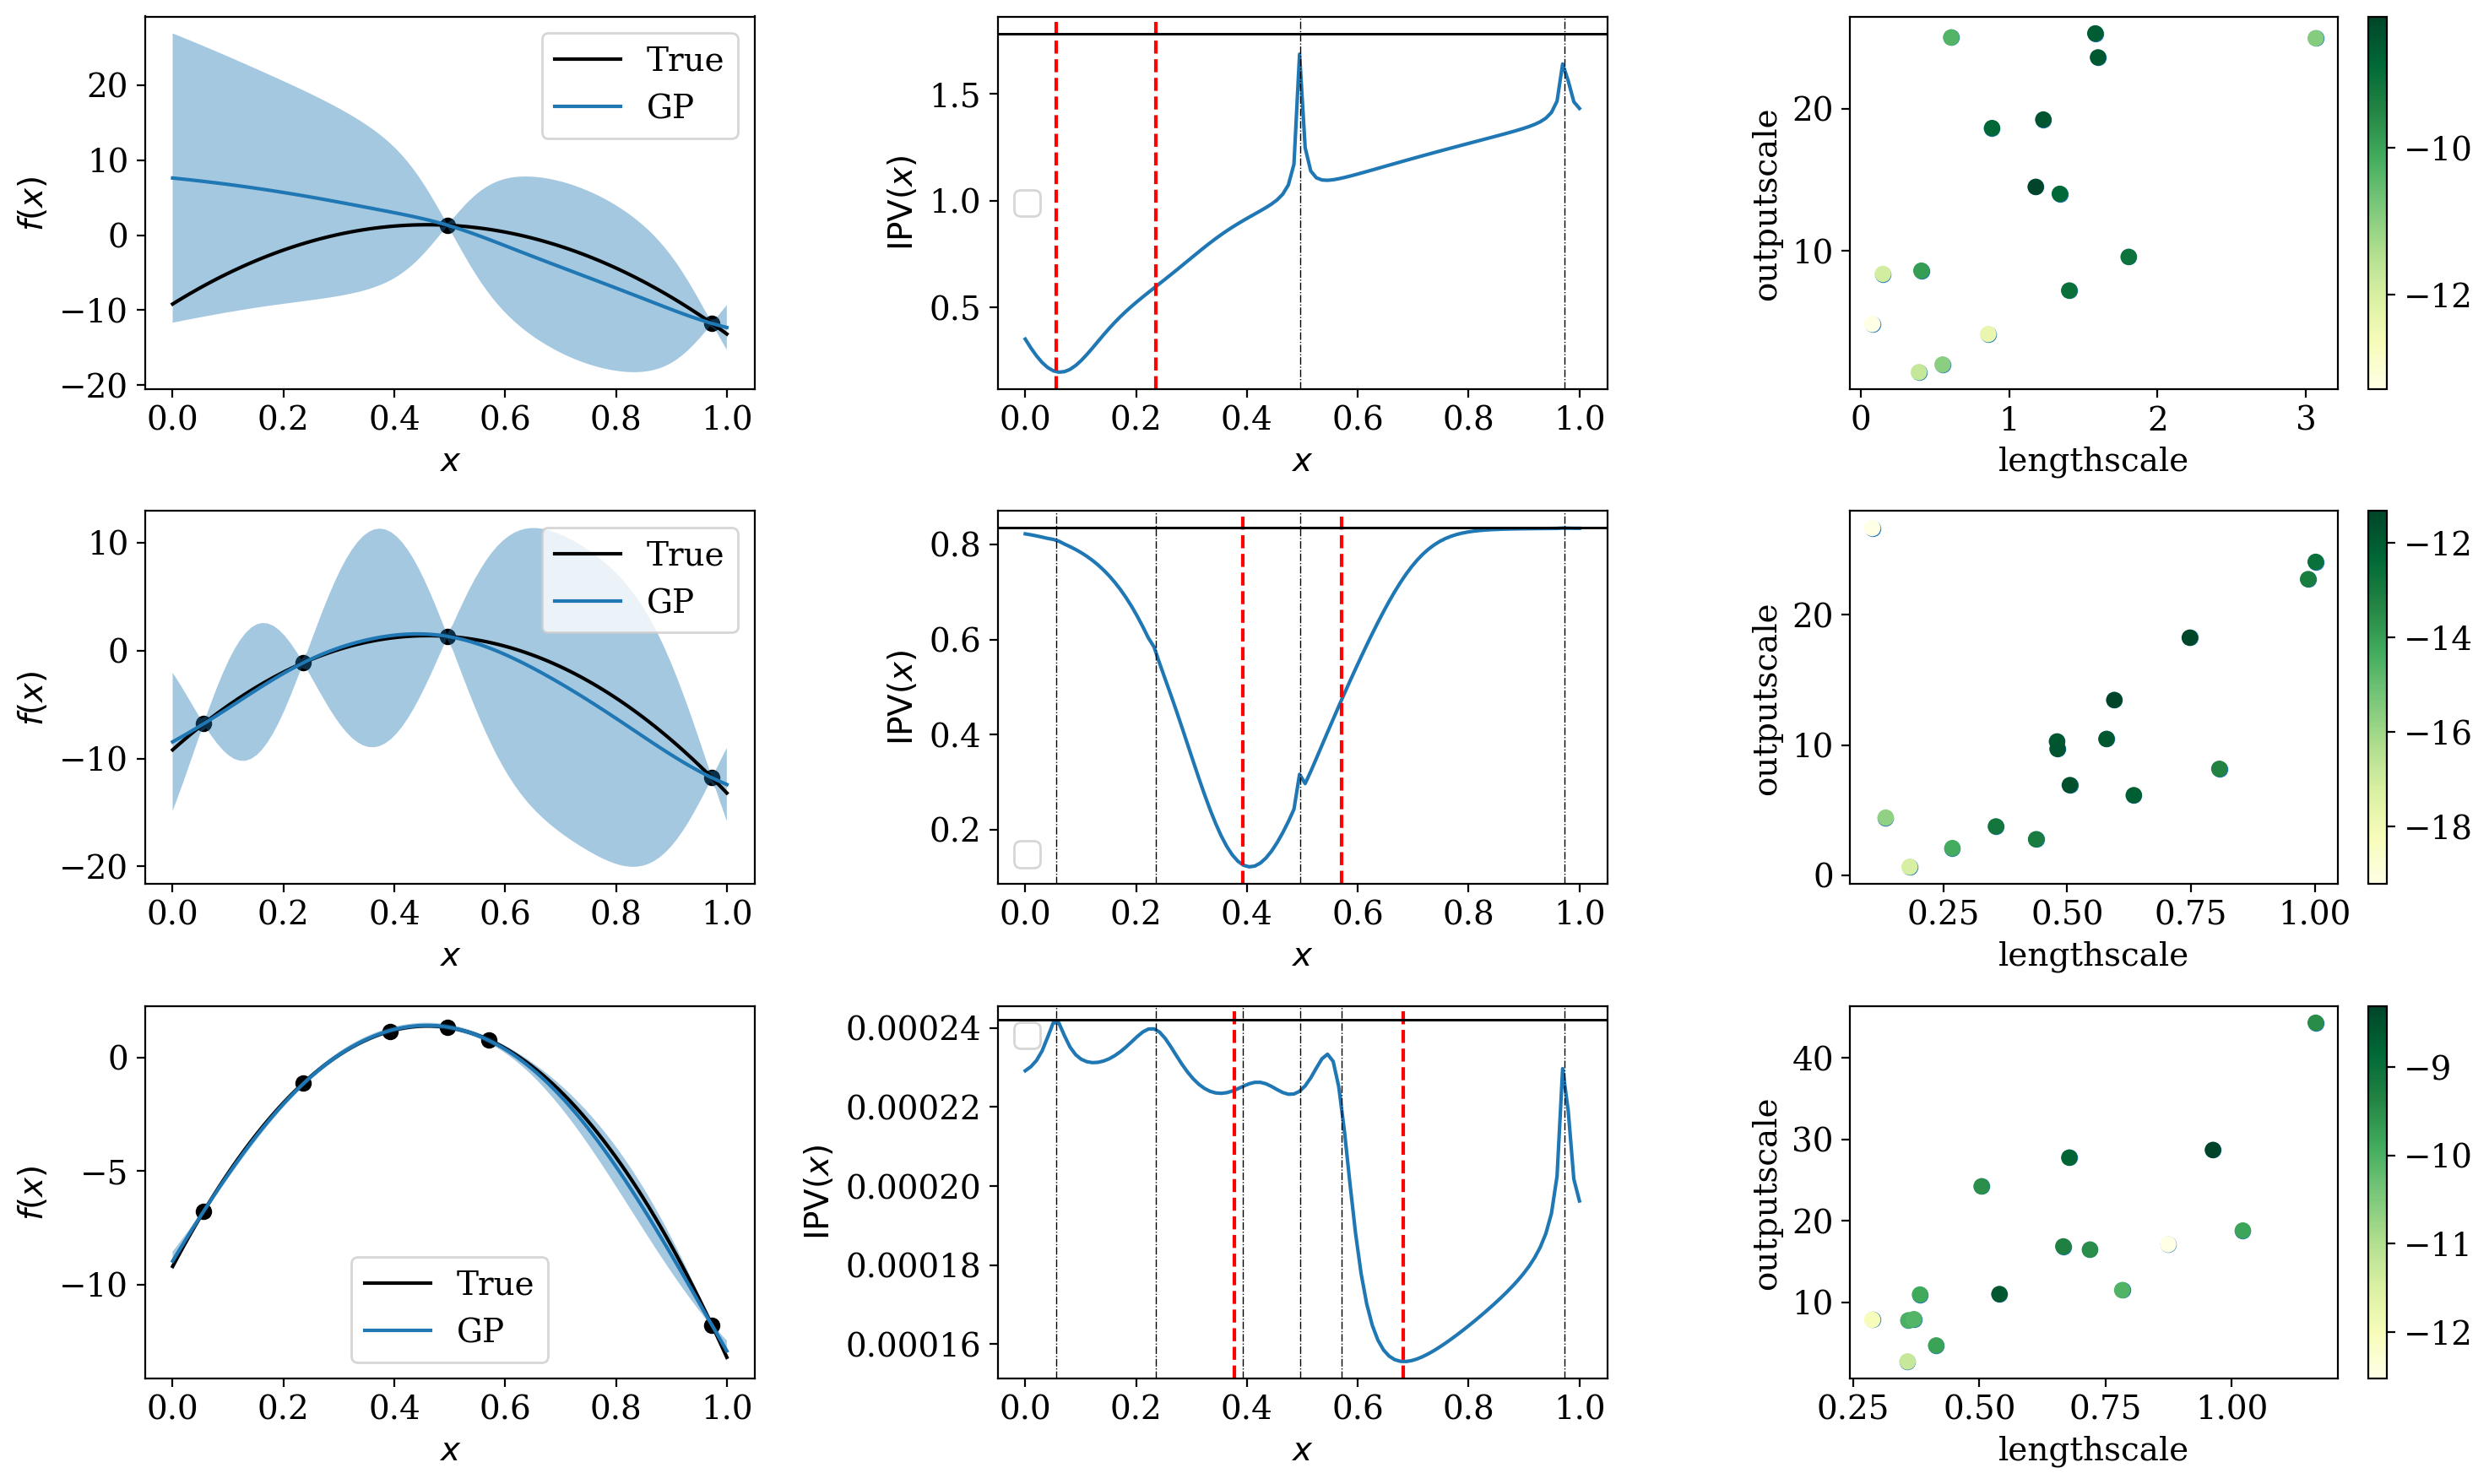

In [20]:
nsteps = 3 # 32
mc_points_size = 8
batch_size = 2

fig, ax = plt.subplots(nsteps,3,figsize=(15,3*nsteps))
start = time.time()
for i in range(nsteps):
    plot_gp(test_x,ax[i,0])
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    plot_hyperparams(gp,fig,ax[i,2])
    print(f"LogZ info "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    mc_points = samples[:mc_points_size,:]
    acq_func = IPV(gp,mc_points,batch_size=batch_size) #   EI(gp,gp.train_y.max()) 
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(size=(2))
    print(x0)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.reshape(results.x,(batch_size,ndim)) #jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    print(next_x.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    acq_vals = vmap(IPV(gp,mc_points,batch_size=1))(test_x) #vmap(acq_func)(test_x)
    # print(acq_vals.shape)
    plot_acq(test_x,acq_vals,next_x,results.fun,mc_points=mc_points,gp=gp,ax=ax[i,1])
    gp = saas_fbgp(train_x,train_y,noise=1e-4)
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.fit(rng_key,warmup_steps=256,num_samples=128,thinning=8,verbose=False)

    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")
fig.tight_layout()